### Project 1

Background:

ACME is one of the fastest growing startups in the logistics and delivery domain. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

Goals:

Predict if a customer is happy or not based on the answers they give to questions asked. 
Which questions/features are more important when predicting a customer’s happiness? 
Is there any question that we can remove in our next surve? 
What is the minimal set of attributes/features that would preserve the most information about the problem?

Success Metrics:

Reach 73% accuracy score or above

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pycaret

from scipy import stats
from scipy.stats import skew

In [2]:
df = pd.read_csv('ACME-HappinessSurvey2020.csv')

In [3]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


Y: target attribute with values 0 for unhappy and 1 for happy customers\
X1: my order was delievered on time\
X2: contents of my order was as I expected\
X3: I ordered everything I wanted to order\
X4: I paid a good price for my order\
X5: I am satisfied with my courier\
X6: the app makes ordering easy for me

In [4]:
# rename
new_names = ['customer_happiness', 'delivered_ontime', 'content_match', 'order_complete', 'price_sat', 'courier_sat', 'app_sat']
old_names = list(df.columns)
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [5]:
df.head()

,customer_happiness,delivered_ontime,content_match,order_complete,price_sat,courier_sat,app_sat
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [6]:
# check data info, data types, and NAs
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   customer_happiness  126 non-null    int64
 1   delivered_ontime    126 non-null    int64
 2   content_match       126 non-null    int64
 3   order_complete      126 non-null    int64
 4   price_sat           126 non-null    int64
 5   courier_sat         126 non-null    int64
 6   app_sat             126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [7]:
df.isnull().sum()

customer_happiness    0
delivered_ontime      0
content_match         0
order_complete        0
price_sat             0
courier_sat           0
app_sat               0
dtype: int64

### Data Visualization and Exploratory Data Analysis

#### distribution of happy and unhappy customers

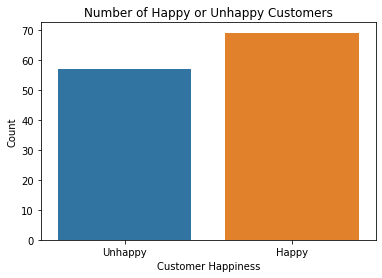

In [8]:
sns.countplot(x = 'customer_happiness', data = df)
plt.xlabel('Customer Happiness')
plt.ylabel('Count')
plt.xticks([0,1],['Unhappy', 'Happy'])
plt.title("Number of Happy or Unhappy Customers")
plt.show()

We have an imbalanced dataset with more happy customers than unhappy customers. We will do some resampling later to balance them out.

Text(0, 0.5, 'Count')

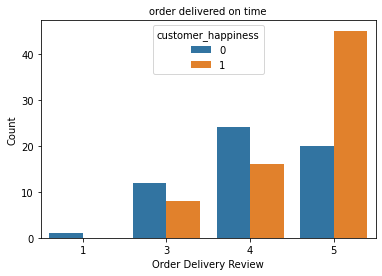

In [9]:
g2 = sns.countplot(x='delivered_ontime', hue='customer_happiness', data=df)
g2.set_title("order delivered on time", fontsize=10)
g2.set_xlabel("Order Delivery Review", fontsize=10)
g2.set_ylabel("Count", fontsize=10)


Happy customers likely to give a higher score, while unhappy customers tend to give a middle score

Text(0, 0.5, 'Count')

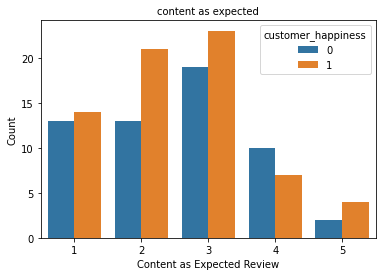

In [10]:
g3 = sns.countplot(x='content_match', hue='customer_happiness', data=df)
g3.set_title("content as expected", fontsize=10)
g3.set_xlabel("Content as Expected Review", fontsize=10)
g3.set_ylabel("Count", fontsize=10)

Text(0, 0.5, 'Count')

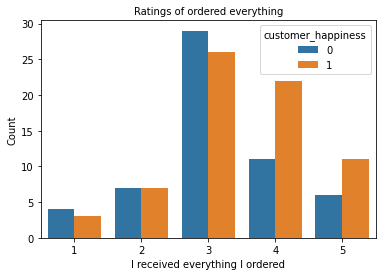

In [11]:
g4 = sns.countplot(x='order_complete', hue='customer_happiness', data=df)
g4.set_title("Ratings of ordered everything", fontsize=10)
g4.set_xlabel("I received everything I ordered", fontsize=10)
g4.set_ylabel("Count", fontsize=10)


Text(0, 0.5, 'Count')

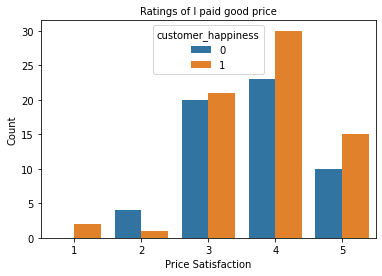

In [12]:
g5 = sns.countplot(x='price_sat', hue='customer_happiness', data=df)
g5.set_title("Ratings of I paid good price", fontsize=10)
g5.set_xlabel("Price Satisfaction", fontsize=10)
g5.set_ylabel("Count", fontsize=10)

Text(0, 0.5, 'Count')

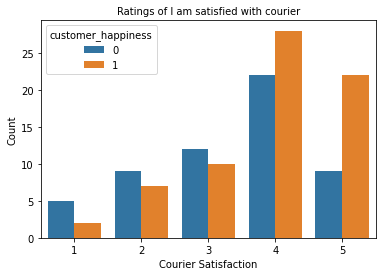

In [13]:
g6 = sns.countplot(x='courier_sat', hue='customer_happiness', data=df)
g6.set_title("Ratings of I am satisfied with courier", fontsize=10)
g6.set_xlabel("Courier Satisfaction", fontsize=10)
g6.set_ylabel("Count", fontsize=10)

Text(0, 0.5, 'Count')

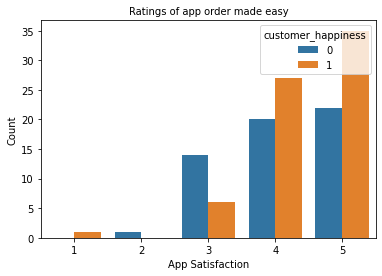

In [14]:
g7 = sns.countplot(x='app_sat', hue='customer_happiness', data=df)
g7.set_title("Ratings of app order made easy", fontsize=10)
g7.set_xlabel("App Satisfaction", fontsize=10)
g7.set_ylabel("Count", fontsize=10)

It looks like happy customers tend to give higher scores for X1, X5 attributes

#### Correlations Between Variables

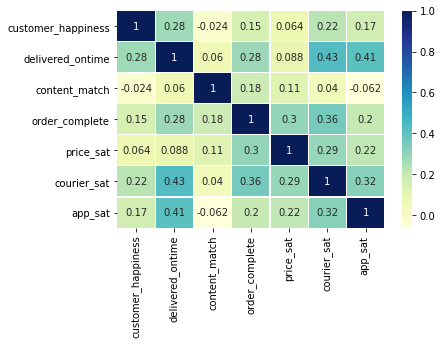

In [15]:
# check for correlations
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

It looks like X1 is most correlated with Y, so we consider to use X1 along first and check for the performance

#### data skewness

In [16]:
df.skew().sort_values(ascending = False)

content_match         0.271000
customer_happiness   -0.193659
order_complete       -0.199536
price_sat            -0.422240
courier_sat          -0.699999
app_sat              -0.957590
delivered_ontime     -1.058468
dtype: float64

Delivery Time is highly negatively skewed, Courier Satisfaction, App Satisfaction, Price Satisfaction are moderately skewed, content_match and order_complete are slightly skewed or normally distributed.

#### bootstrap resampling

In [17]:
# calculate the mean of happiness score
mean = df['customer_happiness'].values.mean()
print('The mean of the dataset is ' + str(mean))

The mean of the dataset is 0.5476190476190477


Since we have a small dataset, we will apply bootstrap method to replicate the experiment and look at the distribution of the means

In [18]:
# bootstrap method: re-sample points with replacement
def bootstrap(sample):
    sample_mean = []
    for i in range(500):
        sample_n = np.random.choice(sample, len(sample))
        sample_mean.append(sample_n.mean())
    return sample_mean

In [19]:
# 95% CI of the means
sample = bootstrap(df['customer_happiness'].values)
sample_dist = sorted(sample)
lb = np.quantile(sample_dist, 0.025)
ub = np.quantile(sample_dist, 0.975)
print('The 95% confidence interval is between {} and {}, so we can conclude that 95% of times that mean reviews will lie in this range'.format(lb, ub))

The 95% confidence interval is between 0.46825396825396826 and 0.6349206349206349, so we can conclude that 95% of times that mean reviews will lie in this range


(array([ 11.,  31.,  66.,  55.,  92., 109.,  54.,  52.,  20.,  10.]),
 array([0.44444444, 0.46587302, 0.48730159, 0.50873016, 0.53015873,
        0.5515873 , 0.57301587, 0.59444444, 0.61587302, 0.63730159,
        0.65873016]),
 <a list of 10 Patch objects>)

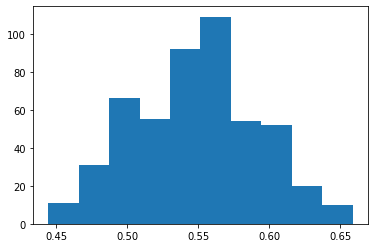

In [20]:
plt.hist(sample_dist)

### Feature Engineering

In [21]:
# skewness transformation using stats.boxcox
d1, l1 = stats.boxcox(df['delivered_ontime'])
d2, l2 = stats.boxcox(df['price_sat'])
d3, l3 = stats.boxcox(df['courier_sat'])
d4, l4 = stats.boxcox(df['app_sat'])

df['delivered_ontime'] = d1
df['price_sat'] = d2
df['courier_sat'] = d3
df['app_sat'] = d4

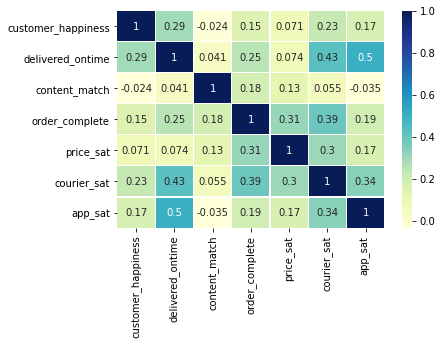

In [22]:
# check for correlations
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

We can see that content_match and price_sat have the lowest correlations with customer_happiness. We may consider dropping the two features when modelling.

In [23]:
df.dtypes

customer_happiness      int64
delivered_ontime      float64
content_match           int64
order_complete          int64
price_sat             float64
courier_sat           float64
app_sat               float64
dtype: object

#### Training and Testing Sets

In [24]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from pycaret.classification import setup, compare_models, tune_model

In [25]:
# complete dataset
X1 = df.drop(['customer_happiness'], axis=1).values
y1 = df['customer_happiness'].values

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state=123)

In [26]:
# drop content_match and price_sat
X2 = df.drop(['customer_happiness', 'content_match', 'price_sat'], axis=1).values
y2 = df['customer_happiness'].values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=123)

In [27]:
# convert to dataframe
def convert_df(x, y):
    df = pd.DataFrame(x)
    df['y'] = y
    return df

In [28]:
df1 = convert_df(X_train1, y_train1)
df2 = convert_df(X_train2, y_train2)

### Modelling

we will use PyCaret package to search for the best ML model

In [29]:
# complete dataset
# setup - preprocessing
clf1 = setup(data = df1, target = df1.columns[-1], html = False, silent = True, verbose = False)

In [30]:
# compare models
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.44


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
dt,Decision Tree Classifier,0.4714,0.4611,0.4667,0.3950,0.4162,-0.0607,-0.0895,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
dt,Decision Tree Classifier,0.4714,0.4611,0.4667,0.3950,0.4162,-0.0607,-0.0895,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
dt,Decision Tree Classifier,0.4714,0.4611,0.4667,0.3950,0.4162,-0.0607,-0.0895,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
rf,Random Forest Classifier,0.5214,0.5069,0.5250,0.5067,0.4913,0.0273,0.0438,0.308
dt,Decision Tree Classifier,0.4714,0.4611,0.4667,0.3950,0.4162,-0.0607,-0.0895,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
rf,Random Forest Classifier,0.5214,0.5069,0.5250,0.5067,0.4913,0.0273,0.0438,0.308
dt,Decision Tree Classifier,0.4714,0.4611,0.4667,0.3950,0.4162,-0.0607,-0.0895,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
rf,Random Forest Classifier,0.5214,0.5069,0.5250,0.5067,0.4913,0.0273,0.0438,0.308
ada,Ada Boost Classifier,0.5024,0.4875,0.5417,0.5238,0.5142,-0.0055,-0.0028,0.113
dt,Decision Tree Classifier,0.4714,0.4611,0.4667,0.3950,0.4162,-0.0607,-0.0895,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
rf,Random Forest Classifier,0.5214,0.5069,0.5250,0.5067,0.4913,0.0273,0.0438,0.308
ada,Ada Boost Classifier,0.5024,0.4875,0.5417,0.5238,0.5142,-0.0055,-0.0028,0.113
gbc,Gradient Boosting Classifier,0.4905,0.4375,0.4583,0.4417,0.4234,-0.0413,-0.0375,0.042
dt,Decision Tree Classifier,0.4714,0.4611,0.4667,0.3950,0.4162,-0.0607,-0.0895,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
lda,Linear Discriminant Analysis,0.5333,0.5736,0.5167,0.5617,0.5055,0.0617,0.0949,0.018
rf,Random Forest Classifier,0.5214,0.5069,0.5250,0.5067,0.4913,0.0273,0.0438,0.308
ada,Ada Boost Classifier,0.5024,0.4875,0.5417,0.5238,0.5142,-0.0055,-0.0028,0.113
gbc,Gradient Boosting Classifier,0.4905,0.4375,0.4583,0.4417,0.4234,-0.0413,-0.0375,0.042


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
et,Extra Trees Classifier,0.5381,0.5653,0.5250,0.4783,0.4845,0.0544,0.0760,0.323
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
lda,Linear Discriminant Analysis,0.5333,0.5736,0.5167,0.5617,0.5055,0.0617,0.0949,0.018
rf,Random Forest Classifier,0.5214,0.5069,0.5250,0.5067,0.4913,0.0273,0.0438,0.308
ada,Ada Boost Classifier,0.5024,0.4875,0.5417,0.5238,0.5142,-0.0055,-0.0028,0.113


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lightgbm,Light Gradient Boosting Machine,0.5786,0.6319,0.5500,0.6267,0.5664,0.1564,0.1817,0.020
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
et,Extra Trees Classifier,0.5381,0.5653,0.5250,0.4783,0.4845,0.0544,0.0760,0.323
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
lda,Linear Discriminant Analysis,0.5333,0.5736,0.5167,0.5617,0.5055,0.0617,0.0949,0.018
rf,Random Forest Classifier,0.5214,0.5069,0.5250,0.5067,0.4913,0.0273,0.0438,0.308


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lightgbm,Light Gradient Boosting Machine,0.5786,0.6319,0.5500,0.6267,0.5664,0.1564,0.1817,0.020
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
et,Extra Trees Classifier,0.5381,0.5653,0.5250,0.4783,0.4845,0.0544,0.0760,0.323
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
lda,Linear Discriminant Analysis,0.5333,0.5736,0.5167,0.5617,0.5055,0.0617,0.0949,0.018
catboost,CatBoost Classifier,0.5238,0.5458,0.5000,0.5300,0.4876,0.0439,0.0477,0.757


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5905,0.6153,0.5167,0.5767,0.5326,0.1634,0.1725,0.015
knn,K Neighbors Classifier,0.5810,0.6639,0.7833,0.5650,0.6508,0.1678,0.1948,0.078
lightgbm,Light Gradient Boosting Machine,0.5786,0.6319,0.5500,0.6267,0.5664,0.1564,0.1817,0.020
qda,Quadratic Discriminant Analysis,0.5524,0.4903,0.4167,0.5650,0.4583,0.0870,0.0890,0.030
et,Extra Trees Classifier,0.5381,0.5653,0.5250,0.4783,0.4845,0.0544,0.0760,0.323
lr,Logistic Regression,0.5357,0.6125,0.5167,0.5283,0.4893,0.0591,0.0838,0.440
svm,SVM - Linear Kernel,0.5333,0.0000,0.4500,0.4600,0.4038,0.0747,0.0990,0.019
ridge,Ridge Classifier,0.5333,0.0000,0.5167,0.5617,0.5055,0.0617,0.0949,0.015
lda,Linear Discriminant Analysis,0.5333,0.5736,0.5167,0.5617,0.5055,0.0617,0.0949,0.018
catboost,CatBoost Classifier,0.5238,0.5458,0.5000,0.5300,0.4876,0.0439,0.0477,0.757


GaussianNB(priors=None, var_smoothing=1e-09)


In [31]:
# drop two features
clf2 = setup(data = df2, target = df2.columns[-1], html = False, silent = True, verbose = False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.619,0.6875,0.6917,0.66,0.661,0.226,0.2542,0.043


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017
svm,SVM - Linear Kernel,0.5143,0.0000,0.4750,0.3005,0.3677,-0.0236,-0.0378,0.034


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017
svm,SVM - Linear Kernel,0.5143,0.0000,0.4750,0.3005,0.3677,-0.0236,-0.0378,0.034


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017
svm,SVM - Linear Kernel,0.5143,0.0000,0.4750,0.3005,0.3677,-0.0236,-0.0378,0.034


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017
svm,SVM - Linear Kernel,0.5143,0.0000,0.4750,0.3005,0.3677,-0.0236,-0.0378,0.034


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017
ada,Ada Boost Classifier,0.5524,0.5431,0.7083,0.5933,0.6399,0.0390,0.0555,0.074
svm,SVM - Linear Kernel,0.5143,0.0000,0.4750,0.3005,0.3677,-0.0236,-0.0378,0.034


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
gbc,Gradient Boosting Classifier,0.6333,0.7042,0.6500,0.7338,0.6661,0.2515,0.2637,0.049
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017
ada,Ada Boost Classifier,0.5524,0.5431,0.7083,0.5933,0.6399,0.0390,0.0555,0.074
svm,SVM - Linear Kernel,0.5143,0.0000,0.4750,0.3005,0.3677,-0.0236,-0.0378,0.034


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
gbc,Gradient Boosting Classifier,0.6333,0.7042,0.6500,0.7338,0.6661,0.2515,0.2637,0.049
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
lda,Linear Discriminant Analysis,0.6190,0.6833,0.6917,0.6600,0.6610,0.2260,0.2542,0.020
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017
ada,Ada Boost Classifier,0.5524,0.5431,0.7083,0.5933,0.6399,0.0390,0.0555,0.074


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
et,Extra Trees Classifier,0.6595,0.6750,0.7000,0.7405,0.7003,0.2962,0.3088,0.277
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
gbc,Gradient Boosting Classifier,0.6333,0.7042,0.6500,0.7338,0.6661,0.2515,0.2637,0.049
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
lda,Linear Discriminant Analysis,0.6190,0.6833,0.6917,0.6600,0.6610,0.2260,0.2542,0.020
nb,Naive Bayes,0.6024,0.7125,0.6917,0.6450,0.6502,0.1927,0.2282,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
et,Extra Trees Classifier,0.6595,0.6750,0.7000,0.7405,0.7003,0.2962,0.3088,0.277
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
gbc,Gradient Boosting Classifier,0.6333,0.7042,0.6500,0.7338,0.6661,0.2515,0.2637,0.049
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
lda,Linear Discriminant Analysis,0.6190,0.6833,0.6917,0.6600,0.6610,0.2260,0.2542,0.020
lightgbm,Light Gradient Boosting Machine,0.6048,0.7208,0.6917,0.6700,0.6586,0.1775,0.2143,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
catboost,CatBoost Classifier,0.6786,0.7806,0.6750,0.7821,0.7053,0.3372,0.3545,0.621
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
et,Extra Trees Classifier,0.6595,0.6750,0.7000,0.7405,0.7003,0.2962,0.3088,0.277
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
gbc,Gradient Boosting Classifier,0.6333,0.7042,0.6500,0.7338,0.6661,0.2515,0.2637,0.049
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
lda,Linear Discriminant Analysis,0.6190,0.6833,0.6917,0.6600,0.6610,0.2260,0.2542,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7976,0.8194,0.7583,0.8883,0.8022,0.6029,0.6352,0.021
knn,K Neighbors Classifier,0.7071,0.8076,0.7833,0.7317,0.7475,0.3663,0.3779,0.084
catboost,CatBoost Classifier,0.6786,0.7806,0.6750,0.7821,0.7053,0.3372,0.3545,0.621
rf,Random Forest Classifier,0.6762,0.7486,0.7000,0.7538,0.7059,0.3317,0.3485,0.328
et,Extra Trees Classifier,0.6595,0.6750,0.7000,0.7405,0.7003,0.2962,0.3088,0.277
dt,Decision Tree Classifier,0.6476,0.6313,0.6833,0.7405,0.6734,0.2893,0.3154,0.018
gbc,Gradient Boosting Classifier,0.6333,0.7042,0.6500,0.7338,0.6661,0.2515,0.2637,0.049
lr,Logistic Regression,0.6190,0.6875,0.6917,0.6600,0.6610,0.2260,0.2542,0.043
ridge,Ridge Classifier,0.6190,0.0000,0.6917,0.6600,0.6610,0.2260,0.2542,0.018
lda,Linear Discriminant Analysis,0.6190,0.6833,0.6917,0.6600,0.6610,0.2260,0.2542,0.020


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


Deal with imbalanced dataset

In [32]:
# Create a new column for happy and unhappy
df['happiness'] = df['customer_happiness'].map({0: 'unhappy', 1:'happy'})

In [33]:
# happy and unhappy customers
con1 = df['customer_happiness']==1
data_happy = df.loc[con1].reset_index(drop = True).drop('happiness', axis = 1)
con2 = df['customer_happiness']==0
data_unhappy = df.loc[con2].reset_index(drop = True).drop('happiness', axis = 1)

array1 = data_happy.values
array2 = data_unhappy.values

print(len(data_happy))
print(len(data_unhappy))

69
57


In [38]:
# We have more happy customers, so make balanced dataset on unhappy customers
# boostrapping method, to make equal list of happy and unhappy customers

# create 100 samples for each
n_sample = 100

# empty list to store happy and unhappy customers
customers_happy = []
customers_unhappy = []

# for loop to store samples of happy customers in the list
for i in range(n_sample):
    idx = np.random.choice(np.arange(0, 50))
    d = list_happy[idx]
    customers_happy.append(d)
    
# for loop to store samples of unhappy customers in the list
for i in range(n_sample):
    idx = np.random.choice(np.arange(0, 50))
    d = list_unhappy[idx]
    customers_unhappy.append(d)

In [39]:
# Create dataframes
happy_df = pd.DataFrame(customers_happy)
happy_df.columns = df.columns[:-1]

unhappy_df = pd.DataFrame(customers_unhappy)
unhappy_df.columns = df.columns[:-1]

data_balanced = pd.concat([happy_df, unhappy_df], axis = 0).reset_index(drop = True)



In [40]:
data_balanced['customer_happiness'].mean()

0.5

In [42]:
# full model

data3_balanced = pd.get_dummies(data_balanced, columns = ['delivered_ontime','content_match', 'order_complete', 'app_sat',
                                       'price_sat', 'courier_sat'], drop_first = False)

X3 = data3_balanced.drop(columns = 'customer_happiness', axis = 1).values
y3 = data3_balanced['customer_happiness'].values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.25, random_state = 123)

In [43]:
# drop content_match and price_sat

data4_balanced = data_balanced[['customer_happiness', 'courier_sat', 'content_match', 'delivered_ontime','app_sat']]

data4_balanced = pd.get_dummies(data4_balanced, columns = ['delivered_ontime','content_match', 'courier_sat', 'app_sat'], drop_first = False)

X4 = data4_balanced.drop(['customer_happiness'], axis=1).values
y4 = data4_balanced['customer_happiness'].values

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.25, random_state=123)

In [44]:
# convert to data frames
df3 = convert_df(X_train3, y_train3)
df4 = convert_df(X_train4, y_train4)

In [45]:
# full model
clf3 = setup(data = df3, target = df3.columns[-1], html = False, silent = True, verbose = False)

best = compare_models()

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7027,0.741,0.73,0.6872,0.701,0.3981,0.4045,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014
qda,Quadratic Discriminant Analysis,0.6236,0.6163,0.9800,0.5857,0.7295,0.2369,0.2824,0.018
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
ada,Ada Boost Classifier,0.6336,0.7357,0.7100,0.6081,0.6469,0.2583,0.2766,0.064
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014
qda,Quadratic Discriminant Analysis,0.6236,0.6163,0.9800,0.5857,0.7295,0.2369,0.2824,0.018
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
gbc,Gradient Boosting Classifier,0.8282,0.8683,0.8267,0.8532,0.8304,0.6522,0.6643,0.088
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
ada,Ada Boost Classifier,0.6336,0.7357,0.7100,0.6081,0.6469,0.2583,0.2766,0.064
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014
qda,Quadratic Discriminant Analysis,0.6236,0.6163,0.9800,0.5857,0.7295,0.2369,0.2824,0.018
nb,Naive Bayes,0.6145,0.6163,0.9800,0.5760,0.7231,0.2169,0.2837,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
gbc,Gradient Boosting Classifier,0.8282,0.8683,0.8267,0.8532,0.8304,0.6522,0.6643,0.088
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
lda,Linear Discriminant Analysis,0.7027,0.7137,0.7300,0.6939,0.7049,0.3981,0.4064,0.022
ada,Ada Boost Classifier,0.6336,0.7357,0.7100,0.6081,0.6469,0.2583,0.2766,0.064
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014
qda,Quadratic Discriminant Analysis,0.6236,0.6163,0.9800,0.5857,0.7295,0.2369,0.2824,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
gbc,Gradient Boosting Classifier,0.8282,0.8683,0.8267,0.8532,0.8304,0.6522,0.6643,0.088
et,Extra Trees Classifier,0.8191,0.9397,0.8467,0.8246,0.8260,0.6329,0.6458,0.314
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
lda,Linear Discriminant Analysis,0.7027,0.7137,0.7300,0.6939,0.7049,0.3981,0.4064,0.022
ada,Ada Boost Classifier,0.6336,0.7357,0.7100,0.6081,0.6469,0.2583,0.2766,0.064
svm,SVM - Linear Kernel,0.6327,0.0000,0.7467,0.6528,0.6540,0.2557,0.2899,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
gbc,Gradient Boosting Classifier,0.8282,0.8683,0.8267,0.8532,0.8304,0.6522,0.6643,0.088
et,Extra Trees Classifier,0.8191,0.9397,0.8467,0.8246,0.8260,0.6329,0.6458,0.314
lightgbm,Light Gradient Boosting Machine,0.7582,0.8053,0.7267,0.7900,0.7404,0.5128,0.5319,0.029
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
lda,Linear Discriminant Analysis,0.7027,0.7137,0.7300,0.6939,0.7049,0.3981,0.4064,0.022
ada,Ada Boost Classifier,0.6336,0.7357,0.7100,0.6081,0.6469,0.2583,0.2766,0.064


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
catboost,CatBoost Classifier,0.8291,0.9223,0.8267,0.8663,0.8323,0.6529,0.6705,0.791
gbc,Gradient Boosting Classifier,0.8282,0.8683,0.8267,0.8532,0.8304,0.6522,0.6643,0.088
et,Extra Trees Classifier,0.8191,0.9397,0.8467,0.8246,0.8260,0.6329,0.6458,0.314
lightgbm,Light Gradient Boosting Machine,0.7582,0.8053,0.7267,0.7900,0.7404,0.5128,0.5319,0.029
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
lda,Linear Discriminant Analysis,0.7027,0.7137,0.7300,0.6939,0.7049,0.3981,0.4064,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8564,0.8623,0.8667,0.8705,0.8601,0.7107,0.7223,0.016
rf,Random Forest Classifier,0.8391,0.9343,0.8667,0.8380,0.8471,0.6729,0.6812,0.348
catboost,CatBoost Classifier,0.8291,0.9223,0.8267,0.8663,0.8323,0.6529,0.6705,0.791
gbc,Gradient Boosting Classifier,0.8282,0.8683,0.8267,0.8532,0.8304,0.6522,0.6643,0.088
et,Extra Trees Classifier,0.8191,0.9397,0.8467,0.8246,0.8260,0.6329,0.6458,0.314
lightgbm,Light Gradient Boosting Machine,0.7582,0.8053,0.7267,0.7900,0.7404,0.5128,0.5319,0.029
knn,K Neighbors Classifier,0.7136,0.7737,0.8067,0.6998,0.7451,0.4149,0.4114,0.075
lr,Logistic Regression,0.7027,0.7410,0.7300,0.6872,0.7010,0.3981,0.4045,0.014
ridge,Ridge Classifier,0.7027,0.0000,0.7300,0.6939,0.7049,0.3981,0.4064,0.034
lda,Linear Discriminant Analysis,0.7027,0.7137,0.7300,0.6939,0.7049,0.3981,0.4064,0.022


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=914, splitter='best')


In [46]:
# drop two features
clf4 = setup(data = df4, target = df4.columns[-1], html = False, silent = True, verbose = False)

best = compare_models()

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.72,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.02


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015
qda,Quadratic Discriminant Analysis,0.4418,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
ada,Ada Boost Classifier,0.7127,0.7823,0.7967,0.7344,0.7566,0.4152,0.4243,0.066
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015
qda,Quadratic Discriminant Analysis,0.4418,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
gbc,Gradient Boosting Classifier,0.8282,0.8200,0.9100,0.8207,0.8556,0.6407,0.6697,0.051
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
ada,Ada Boost Classifier,0.7127,0.7823,0.7967,0.7344,0.7566,0.4152,0.4243,0.066
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015
qda,Quadratic Discriminant Analysis,0.4418,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
gbc,Gradient Boosting Classifier,0.8282,0.8200,0.9100,0.8207,0.8556,0.6407,0.6697,0.051
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lda,Linear Discriminant Analysis,0.7400,0.7673,0.8800,0.7331,0.7901,0.4631,0.4980,0.025
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
ada,Ada Boost Classifier,0.7127,0.7823,0.7967,0.7344,0.7566,0.4152,0.4243,0.066
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017
nb,Naive Bayes,0.6645,0.7345,1.0000,0.6289,0.7695,0.2719,0.3760,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
gbc,Gradient Boosting Classifier,0.8282,0.8200,0.9100,0.8207,0.8556,0.6407,0.6697,0.051
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
et,Extra Trees Classifier,0.8082,0.8893,0.8767,0.8124,0.8366,0.6028,0.6251,0.328
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lda,Linear Discriminant Analysis,0.7400,0.7673,0.8800,0.7331,0.7901,0.4631,0.4980,0.025
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
ada,Ada Boost Classifier,0.7127,0.7823,0.7967,0.7344,0.7566,0.4152,0.4243,0.066
svm,SVM - Linear Kernel,0.6955,0.0000,0.8100,0.7255,0.7384,0.3706,0.4065,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
gbc,Gradient Boosting Classifier,0.8282,0.8200,0.9100,0.8207,0.8556,0.6407,0.6697,0.051
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
et,Extra Trees Classifier,0.8082,0.8893,0.8767,0.8124,0.8366,0.6028,0.6251,0.328
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lightgbm,Light Gradient Boosting Machine,0.7436,0.7782,0.8433,0.7439,0.7849,0.4703,0.4873,0.027
lda,Linear Discriminant Analysis,0.7400,0.7673,0.8800,0.7331,0.7901,0.4631,0.4980,0.025
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020
ada,Ada Boost Classifier,0.7127,0.7823,0.7967,0.7344,0.7566,0.4152,0.4243,0.066


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
gbc,Gradient Boosting Classifier,0.8282,0.8200,0.9100,0.8207,0.8556,0.6407,0.6697,0.051
catboost,CatBoost Classifier,0.8282,0.8572,0.9100,0.8207,0.8556,0.6407,0.6697,0.720
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
et,Extra Trees Classifier,0.8082,0.8893,0.8767,0.8124,0.8366,0.6028,0.6251,0.328
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lightgbm,Light Gradient Boosting Machine,0.7436,0.7782,0.8433,0.7439,0.7849,0.4703,0.4873,0.027
lda,Linear Discriminant Analysis,0.7400,0.7673,0.8800,0.7331,0.7901,0.4631,0.4980,0.025
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8282,0.8497,0.9100,0.8207,0.8556,0.6407,0.6697,0.339
gbc,Gradient Boosting Classifier,0.8282,0.8200,0.9100,0.8207,0.8556,0.6407,0.6697,0.051
catboost,CatBoost Classifier,0.8282,0.8572,0.9100,0.8207,0.8556,0.6407,0.6697,0.720
dt,Decision Tree Classifier,0.8264,0.8189,0.8933,0.8207,0.8514,0.6408,0.6572,0.015
et,Extra Trees Classifier,0.8082,0.8893,0.8767,0.8124,0.8366,0.6028,0.6251,0.328
knn,K Neighbors Classifier,0.8073,0.7884,0.8733,0.8225,0.8379,0.5950,0.6185,0.071
ridge,Ridge Classifier,0.7491,0.0000,0.8800,0.7398,0.7951,0.4838,0.5150,0.032
lightgbm,Light Gradient Boosting Machine,0.7436,0.7782,0.8433,0.7439,0.7849,0.4703,0.4873,0.027
lda,Linear Discriminant Analysis,0.7400,0.7673,0.8800,0.7331,0.7901,0.4631,0.4980,0.025
lr,Logistic Regression,0.7200,0.7595,0.8467,0.7267,0.7716,0.4275,0.4386,0.020


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1879, verbose=0,
                       warm_start=False)


we will use the dataset without the two features

In [48]:
# final model variables
X = df4.drop(columns = 'y', axis = 1).values
y = df4['y'].values

# Divition of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

#### models
we will use Random Forest, Gradient Boosting, Decision Tree, and CatBoost, and depending on the results of the models, a voting classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier

#### Random Forest

In [50]:
%%time
param_grid = {'n_estimators': [50, 100, 150, 200, 250],
              'criterion' : ['gini', 'entropy'],
              'max_depth': [3, 5, 7],
              }

rf = RandomForestClassifier()
cv_rf = GridSearchCV(rf, param_grid, cv = 5)
cv_rf_fit = cv_rf.fit(X_train, y_train)

print(cv_rf_fit.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 150}
CPU times: user 32.4 s, sys: 316 ms, total: 32.8 s
Wall time: 32.9 s


In [51]:
rf = RandomForestClassifier(criterion = 'gini',max_depth = 7, n_estimators = 150)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [52]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.71      0.79        21
         1.0       0.71      0.88      0.79        17

    accuracy                           0.79        38
   macro avg       0.80      0.80      0.79        38
weighted avg       0.81      0.79      0.79        38



In [53]:
print("Accuracy score {:.4f}".format(accuracy_score(y_test, rf_pred)))

Accuracy score 0.7895


In [54]:
rf_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rf_pred_prob)


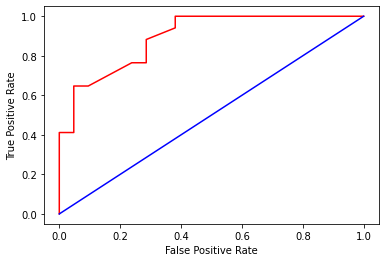

In [55]:
plt.plot(fpr, tpr, color = 'red')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Decision Tree

In [56]:
param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': [3, 5, 7],
             'min_samples_split':[2, 4, 6, 8]
             }

dt = DecisionTreeClassifier()
cv_dt = GridSearchCV(dt, param_grid, cv = 5)
cv_dt_fit = cv_dt.fit(X_train, y_train)

print(cv_dt_fit.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 4}


In [57]:
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_split = 4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)


In [58]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        21
         1.0       0.75      0.88      0.81        17

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.83      0.82      0.82        38



In [59]:
print("Accuracy score {:.4f}".format(accuracy_score(y_test, dt_pred)))

Accuracy score 0.8158


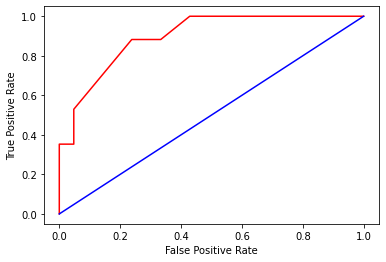

In [60]:
dt_pred_prob = dt.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, dt_pred_prob)

plt.plot(fpr, tpr, color = 'red')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Gradient Boosting

In [63]:
param_grid = {'n_estimators':[50, 100, 150, 200],
              'max_depth':[3,5,7,9], 
              'min_samples_split':[2,4,6,8]
             }

gb = GradientBoostingClassifier()
cv_gb = GridSearchCV(gb, param_grid, cv = 5)
cv_gb_fit = cv_gb.fit(X_train, y_train)

print(cv_gb_fit.best_params_)

{'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 50}


In [69]:
gb = GradientBoostingClassifier(n_estimators = 50, max_depth = 5, min_samples_split = 8)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

In [70]:
print(classification_report(y_test, gb_pred))
print("Accuracy score {:.4f}".format(accuracy_score(y_test, gb_pred)))

              precision    recall  f1-score   support

         0.0       0.88      0.71      0.79        21
         1.0       0.71      0.88      0.79        17

    accuracy                           0.79        38
   macro avg       0.80      0.80      0.79        38
weighted avg       0.81      0.79      0.79        38

Accuracy score 0.7895


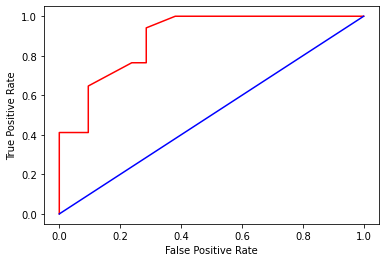

In [71]:
gb_pred_prob = gb.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, gb_pred_prob)

plt.plot(fpr, tpr, color = 'red')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### CatBoost

In [ ]:
## parameter griding for CatBoost, already run

param_grid = {'depth':[3,5,7,9],
              'iterations':[10, 25, 50],
              'learning_rate':[0.001,0.01,0.1, 0.2]
             }

cb = CatBoostClassifier()
cv_cb = GridSearchCV(cb, param_grid, cv = 5)
cv_cb_fit = cv_cb.fit(X_train, y_train)

print(cv_cb_fit.best_params_)
# best params: 'iterations': 50, 'depth': 9, 'learning_rate': 0.2

In [72]:
cb = CatBoostClassifier(iterations = 50, depth = 9, learning_rate = 0.2)
cb.fit(X_train, y_train)
cb_pred = cb.predict(X_test)

0:	learn: 0.6553198	total: 1.53ms	remaining: 74.8ms
1:	learn: 0.6441459	total: 2.2ms	remaining: 52.9ms
2:	learn: 0.6183117	total: 4.41ms	remaining: 69.1ms
3:	learn: 0.5922494	total: 5.19ms	remaining: 59.7ms
4:	learn: 0.5820223	total: 5.74ms	remaining: 51.6ms
5:	learn: 0.5641038	total: 6.63ms	remaining: 48.6ms
6:	learn: 0.5543837	total: 7.61ms	remaining: 46.8ms
7:	learn: 0.5417780	total: 8.75ms	remaining: 45.9ms
8:	learn: 0.5243751	total: 9.72ms	remaining: 44.3ms
9:	learn: 0.5145332	total: 11.1ms	remaining: 44.2ms
10:	learn: 0.4988272	total: 12.9ms	remaining: 45.8ms
11:	learn: 0.4858448	total: 14.4ms	remaining: 45.7ms
12:	learn: 0.4727817	total: 16.1ms	remaining: 45.7ms
13:	learn: 0.4603684	total: 18.9ms	remaining: 48.5ms
14:	learn: 0.4550404	total: 19.8ms	remaining: 46.3ms
15:	learn: 0.4484957	total: 20.7ms	remaining: 44ms
16:	learn: 0.4389166	total: 22.3ms	remaining: 43.4ms
17:	learn: 0.4343610	total: 24.1ms	remaining: 42.9ms
18:	learn: 0.4299760	total: 26.5ms	remaining: 43.2ms
19:	le

In [73]:
print(classification_report(y_test, cb_pred))
print("Accuracy score {:.4f}".format(accuracy_score(y_test, cb_pred)))

              precision    recall  f1-score   support

         0.0       0.88      0.71      0.79        21
         1.0       0.71      0.88      0.79        17

    accuracy                           0.79        38
   macro avg       0.80      0.80      0.79        38
weighted avg       0.81      0.79      0.79        38

Accuracy score 0.7895


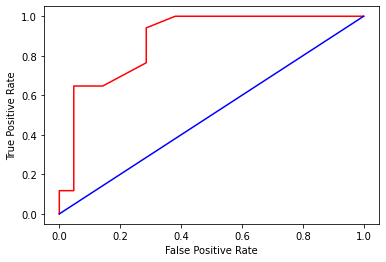

In [74]:
cb_pred_prob = cb.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, cb_pred_prob)

plt.plot(fpr, tpr, color = 'red')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Voting Classifier

In [75]:
clf1 = RandomForestClassifier(criterion = 'gini',max_depth = 7, n_estimators = 150)

clf2 = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_split = 4)

clf3 = GradientBoostingClassifier(n_estimators = 50, max_depth = 5, min_samples_split = 8)

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2), ('est3', clf3)], voting = 'soft')

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

In [76]:
print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        21
         1.0       0.75      0.88      0.81        17

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.83      0.82      0.82        38



In [78]:
print('Voting accuracy score: {:.4f}'.format(accuracy_score(y_test, pred_voting)))

Voting accuracy score: 0.8158


#### Weights to each classifier

In [79]:
# empty list to store different weights
weights1 = []
weights2 = []
weights3 = []
scores = []

# try different combination of weights
for i in np.arange(0.1,1, 0.1):
    for j in np.arange(0.1,1, 0.1):
        for k in np.arange(0.1,1, 0.1):
            clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)], voting = 'soft', weights = [i, j, k])
            clf_voting.fit(X_train, y_train)
            pred = clf_voting.predict(X_test)
            score = accuracy_score(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

In [81]:
test_scores = pd.DataFrame()
test_scores['RandomForest'] = weights1
test_scores['DecisionTree'] = weights2
test_scores['GradientBoosting'] = weights3
test_scores['TestScore'] = scores

test_scores['sum_weights'] = test_scores['RandomForest'].add(test_scores['DecisionTree']).add(test_scores['GradientBoosting'])

# getting the rows where sum is equal to 1
condition = test_scores['sum_weights'] == 1

test_scores = test_scores.loc[condition]

# sort values to see the top 10 scores
test_scores.sort_values(by = 'TestScore', ascending = False).head(10)

,RandomForest,DecisionTree,GradientBoosting,TestScore,sum_weights
191,0.3,0.4,0.3,0.815789,1.0
111,0.2,0.4,0.4,0.815789,1.0
271,0.4,0.4,0.2,0.815789,1.0
263,0.4,0.3,0.3,0.815789,1.0
255,0.4,0.2,0.4,0.815789,1.0
343,0.5,0.3,0.2,0.815789,1.0
207,0.3,0.6,0.1,0.815789,1.0
199,0.3,0.5,0.2,0.815789,1.0
351,0.5,0.4,0.1,0.815789,1.0
183,0.3,0.3,0.4,0.815789,1.0


In [83]:
# Create voting classifier with most equally weighted

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2), ('est3', clf3)], voting = 'soft', weights = [0.3, 0.4, 0.3])

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

In [84]:
print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        21
         1.0       0.75      0.88      0.81        17

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.83      0.82      0.82        38



In [85]:
print('Voting accuracy score: {:.4f}'.format(accuracy_score(y_test, pred_voting)))

Voting accuracy score: 0.8158


#### Feature Importance

In [89]:
# we run a permutation test to calculate feature importances in the dataset
r = permutation_importance(clf_voting , X_test, y_test, n_repeats = 30, random_state = 123)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f" {data4_balanced.columns[i]:<8} "
              f" {r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f} ")

 courier_sat_0.0  0.129  +/- 0.045 
 delivered_ontime_26.45962443532881  0.090  +/- 0.038 
 content_match_5.0  0.030  +/- 0.009 


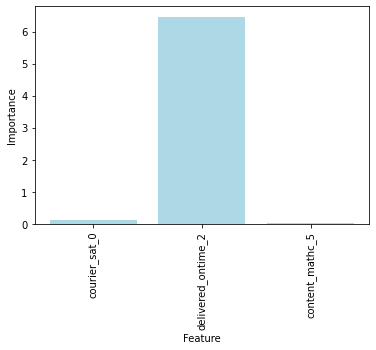

In [91]:
# plot important features
features = ['courier_sat_0', 'delivered_ontime_2', 'content_mathc_5']
importance = [0.129, 6.45962443532881, 0.030]

plt.bar(x = features, height = importance, color = 'lightblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation = 90)
plt.show()

### Conclusion

The best model is the voting classifier, with Random Forest, Decision Trees, and Gradient Boosting. The accuracy is 0.8158, f1 score is 0.82 for unhappy and 0.81 for happy customers.

The feature that impact customer happiness the most is whether the order is delivered on time.

#### Final Model

In [ ]:
#import pickle
#s = pickle.dumps(clf_voting)
#from joblib import dump, load
#dump(clf_voting, 'happycustomer')